## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1. 

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents. 

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [1]:
import pandas as pd

# Load the dataset
url = 'https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet'
df = pd.read_parquet(url)

# Tokenize the email text using str.split()
df['Tokens'] = df['Email Text'].str.split()

# Display the first few rows of the dataset with the tokens
print(df[['Email Text', 'Tokens']].head())


                                          Email Text  \
0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1  the other side of * galicismos * * galicismo *...   
2  re : equistar deal tickets are you still avail...   
3  \nHello I am your hot lil horny toy.\n    I am...   
4  software at incredibly low prices ( 86 % lower...   

                                              Tokens  
0  [re, :, 6, ., 1100, ,, disc, :, uniformitarian...  
1  [the, other, side, of, *, galicismos, *, *, ga...  
2  [re, :, equistar, deal, tickets, are, you, sti...  
3  [Hello, I, am, your, hot, lil, horny, toy., I,...  
4  [software, at, incredibly, low, prices, (, 86,...  


Remove Punctuation: Remove symbols and punctuation to ensure only words remain.
Convert to Lowercase: Normalize the text by converting all characters to lowercase.
Remove Stopwords: Remove common but uninformative words like "and," "the," "is," etc., as they usually don't contribute to distinguishing phishing from safe emails. Use accuracy, precision, recall, F1-score, and ROC-AUC to evaluate performance, ensuring the model effectively distinguishes phishing from safe emails.

### Q2. 

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

<Axes: >

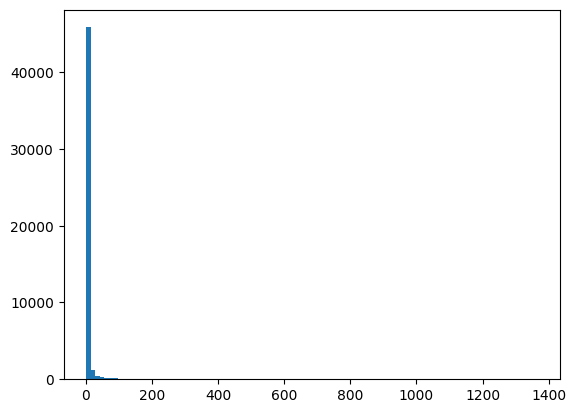

In [6]:
import pickle
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

gdf = pd.DataFrame(token_freq,columns=['token','count'])
gdf['count'].hist(grid=False,bins=100)

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

There is a very long tail, and most tokens only appear once or a small number of times

### Q3. 

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions? 

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
import numpy as np

# Load the dataset
df = pd.read_parquet("Phishing_clean.parquet")

# 1. Perform an 80/20 train-test split
X = df.drop(columns=['Email Type'])
y = df['Email Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Run a regression of y on the one-hot-encoded emails
model = LogisticRegression(max_iter=10000, random_state=42)
model.fit(X_train, y_train)

# Predict on train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate R^2 scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R^2 on Training Set: {r2_train:.4f}")
print(f"R^2 on Test Set: {r2_test:.4f}")

# 3. Find words with the largest coefficients in absolute value
coefficients = model.coef_[0]
features = X.columns

# Create a DataFrame of coefficients and words
coef_df = pd.DataFrame({'Word': features, 'Coefficient': coefficients})
coef_df['Abs Coefficient'] = np.abs(coef_df['Coefficient'])

# Sort by absolute value of coefficients
top_words = coef_df.sort_values(by='Abs Coefficient', ascending=False).head(10)

print("\nTop Words with Largest Coefficients (Absolute Value):")
print(top_words)


R^2 on Training Set: 0.8597
R^2 on Test Set: 0.7566

Top Words with Largest Coefficients (Absolute Value):
          Word  Coefficient  Abs Coefficient
4        enron    -4.308871         4.308871
16        url:    -4.144157         4.144157
35       vince    -3.083769         3.083769
22      wrote:    -3.058260         3.058260
88      louise    -2.956818         2.956818
168  forwarded    -2.571457         2.571457
25    language    -2.500870         2.500870
103      wrote    -2.471931         2.471931
205      daren    -2.410629         2.410629
818       cnet    -2.268266         2.268266


### Q4. 

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

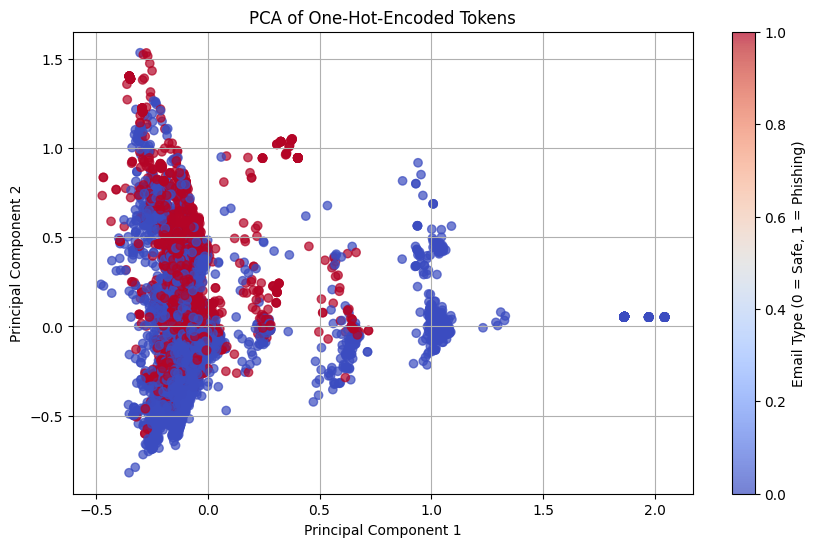

In [15]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_parquet("Phishing_clean.parquet")

# Separate features (X) and the outcome variable (y)
X = df.drop(columns=['Email Type'])
y = df['Email Type']

# Perform PCA with two components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot of the first two principal components
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, label='Email Type (0 = Safe, 1 = Phishing)')
plt.title('PCA of One-Hot-Encoded Tokens')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


There appears to be partial clustering of phishing emails (red points) and safe emails (blue points) along the principal components.
However, there is significant overlap, indicating that phishing and safe emails share common token patterns that make them less distinct in this 2D PCA space.

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [17]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Load the dataset
df = pd.read_parquet("Phishing_clean.parquet")

# Separate features and target variable
X = df.drop(columns=['Email Type'])
y = df['Email Type']

# Perform PCA and retain 2,610 components
pca = PCA(n_components=2610)
X_pca = pca.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Run linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate R^2 on training and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R^2 on Training Set: {r2_train:.4f}")
print(f"R^2 on Test Set: {r2_test:.4f}")


R^2 on Training Set: 0.7662
R^2 on Test Set: 0.6684


PCA reduced the feature set to 2,610 components, capturing most of the variance while discarding less useful noise-like dimensions. The PCA-based regression has a smaller gap between training and test compared to the one-hot-encoded regression. This indicates that the PCA model generalizes better and is less prone to overfitting.

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

PCA simplifies the high-dimensional feature space into a more manageable, noise-free representation, improving model performance and interpretability in high-dimensional contexts. Principal components summarize the data into fewer, uncorrelated features while retaining most of the variance.